In [1]:
import pickle
import numpy as np

import multiprocessing
import os
import time
import numpy as np
from scipy.spatial import cKDTree
import open3d as o3d
import util
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from BendLength import BendLengthCalculator
import pandas as pd
from IPython.display import display

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
point_cloud_location = "C:/Users/chris/Desktop/Documents/Code/PointClouds/sampled_model.ply"
pcd = o3d.io.read_point_cloud(point_cloud_location)

# Preprocess the point cloud
pcd = util.preProcessCloud(pcd)
pcd_points = np.asarray(pcd.points)

In [3]:
with open("bend_visualization_data_cad.pkl", "rb") as f:
    data = pickle.load(f)

intersection_line = data["intersection_line"]
bend_edges = data["bend_edges"]
cluster_points = data["cluster_points"]
cluster_derivatives = data["cluster_derivatives"]
all_normals = data["all_normals"]
segment_indices = data["segment_indices"]

In [ ]:
class ArcLengthCalculator:
    def __init__(self, pcd, intersection_line, bend_edges, bend_cluster_points, cluster_derivatives, all_normals, segment_indices, intersection_step_size=0.5, derivative_step_size=0.04, radius=2.1):
        self.pcd = pcd
        self.points = np.asarray(pcd.points)

        if len(pcd.points) != len(all_normals):
            raise ValueError(f"Mismatch: {len(pcd.points)} points in PCD, but {len(all_normals)} normals loaded. "
                     "Make sure the point cloud is preprocessed the same way.")
        else:
            print(f"Loaded {len(all_normals)} normals for {len(pcd.points)} points in PCD. Proceeding.")
        self.intersection_line = intersection_line
        self.bend_cluster_points = bend_cluster_points
        self.bend_cluster_derivatives = cluster_derivatives
        self.bend_cluster_kdtree = cKDTree(self.bend_cluster_points)
        self.pcd_kdtree = cKDTree(self.points)
        self.start_point, self.end_point = map(np.array, bend_edges)
        self.intersection_step_size = intersection_step_size
        self.derivative_step_size = derivative_step_size
        self.all_normals = all_normals
        self.segment_indices = segment_indices
        self.radius = 2.5
        self.intersection_it = 0
        self.derivative_it = 0
        self.is_moving_forward = True

        self.pcd.paint_uniform_color([0.6, 0.6, 0.6])
        self.vis = o3d.visualization.Visualizer()
        self.vis.create_window("ArcLengthCalculator")
        self.vis.add_geometry(self.pcd)

        self.plane_dominant_bins = {}
        for plane_id in [0, 1]:
            self.plane_dominant_bins[plane_id] = self.get_dominant_bin_ranges(
                self.all_normals[self.segment_indices[plane_id]],
                threshold=0.2,
                bin_size=1
            )

    def plot_histogram_with_dominant_bins(self, angles, bin_edges, dominant_ranges, title, color):
        import matplotlib.pyplot as plt
        counts, edges, bars = plt.hist(angles, bins=bin_edges, color=color, edgecolor='black')
        # for i, bar in enumerate(bars):
        #     bin_start = edges[i]
        #     bin_end = edges[i+1]
        #     for dom_start, dom_end in dominant_ranges:
        #         if np.isclose(bin_start, dom_start, atol=1e-6) and np.isclose(bin_end, dom_end, atol=1e-6):
        #             bar.set_color('green')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def get_dominant_bin_ranges(self, normals, threshold=0.2, bin_size=1):
        dominant_bins = {}

        azimuth = np.degrees(np.arctan2(normals[:, 1], normals[:, 0]))
        az_hist, az_edges = np.histogram(azimuth, bins=np.arange(-180, 181, bin_size))
        az_ranges = []
        for i in range(len(az_hist)):
            if az_hist[i] / len(azimuth) > threshold:
                for offset in [-1, 0, 1]:
                    idx = i + offset
                    if 0 <= idx < len(az_hist):
                        az_ranges.append((az_edges[idx], az_edges[idx + 1]))

        zenith = np.degrees(np.arccos(np.clip(normals[:, 2], -1, 1)))
        zen_hist, zen_edges = np.histogram(zenith, bins=np.arange(0, 181, bin_size))
        zen_ranges = []
        for i in range(len(zen_hist)):
            if zen_hist[i] / len(zenith) > threshold:
                for offset in [-2, 0, 2]:
                    idx = i + offset
                    if 0 <= idx < len(zen_hist):
                        zen_ranges.append((zen_edges[idx], zen_edges[idx + 1]))
                        
        dominant_bins["azimuth"] = az_ranges
        dominant_bins["zenith"] = zen_ranges
        self.plot_histogram_with_dominant_bins(azimuth, az_edges, az_ranges, "Azimuth Histogram", color='skyblue')
        self.plot_histogram_with_dominant_bins(zenith, zen_edges, zen_ranges, "Zenith Histogram", color='salmon')

        return dominant_bins

    def is_normal_in_any_bin(self, normal, bin_ranges, mode):
        if mode == "azimuth":
            angle = np.degrees(np.arctan2(normal[1], normal[0]))
        elif mode == "zenith":
            angle = np.degrees(np.arccos(np.clip(normal[2], -1, 1)))
        else:
            raise ValueError("Invalid mode: choose 'azimuth' or 'zenith'")

        for start, end in bin_ranges:
            if start <= angle <= end:
                return True
        return False
    
    def check_plane_alignment(self, normal):
        """Returns a dict indicating whether the normal aligns with plane 0 or 1."""
        result = {}

        for plane_id in [0, 1]:
            bins = self.plane_dominant_bins[plane_id]
            az_bins = bins.get("azimuth", [])
            zen_bins = bins.get("zenith", [])

            az_match = self.is_normal_in_any_bin(normal, az_bins, "azimuth") if az_bins else True
            zen_match = self.is_normal_in_any_bin(normal, zen_bins, "zenith") if zen_bins else True

            # Require both if both bins are present, otherwise just match the available one
            result[plane_id] = az_match and zen_match

        return result
    
    def find_hemisphere_normal(self, neighborhood_points):
        mean = np.mean(neighborhood_points, axis=0)
        centered = neighborhood_points - mean
        cov = np.cov(centered.T)
        eig_vals, eig_vecs = np.linalg.eigh(cov)
        eig_vecs = eig_vecs[:, np.argsort(eig_vals)]  # ascending order

        pca_normal = eig_vecs[:, 0]  # Smallest eigenvalue → normal direction
        return pca_normal
    
    def align_normals(self, reference_normal, neighbor_directions):
        aligned_normals = np.array(neighbor_directions)
        
        # Check dot product: If negative, flip the normal
        for i in range(len(aligned_normals)):
            if np.dot(reference_normal, aligned_normals[i]) < 0:
                aligned_normals[i] = -aligned_normals[i]

        return aligned_normals

    def compute_piecewise_arc_length(self, points):
        return np.sum(np.linalg.norm(np.diff(points, axis=0), axis=1))

    def hug_surface(self, last_bend_point): 
        neighbor_indices = self.bend_cluster_kdtree.query(last_bend_point, k=15)[1]
        neighbor_points = self.bend_cluster_points[neighbor_indices]
        mean = np.mean(neighbor_points, axis=0)
        centered = neighbor_points - mean
        cov = np.cov(centered.T)
        eig_vals, eig_vecs = np.linalg.eigh(cov)
        eig_vecs = eig_vecs[:, np.argsort(eig_vals)]
        pca_normal = eig_vecs[:, 0]

        vec_to_point = last_bend_point - mean
        distance = np.dot(vec_to_point, pca_normal)
        projection = mean - distance * pca_normal
        return projection
    
    def find_bend_end(self, bend_point, derivate_direction):
        initial_direction = derivate_direction.copy()
        path_points = [bend_point.copy()]
        i=0
        while True:
            neighbor_all_indices = self.pcd_kdtree.query_ball_point(bend_point, self.radius)
            if len(neighbor_all_indices) > 5:
                # Separate neighbors by hemisphere
                neighbor_points = self.points[neighbor_all_indices]
                # FULL HEMISPHERE
                # vectors = neighbor_points - bend_point
                # dot_products = vectors @ derivate_direction
                # forward_mask = dot_products > 0
                # forward_indices = np.array(neighbor_all_indices)[forward_mask]
                # #print(f"Forward indices: {forward_indices}")
                # forward_points = self.points[forward_indices]
                # pca_normal = self.find_hemisphere_normal(forward_points)

                # SLAB FORWARD STRUCTURE
                vectors = neighbor_points - bend_point
                dot_products = vectors @ derivate_direction
                epsilon = 0.35
                mask_1 = np.abs(dot_products) < epsilon
                mask_2 = dot_products > 0
                final_mask = mask_1 & mask_2
                forward_indices = np.array(neighbor_all_indices)[final_mask]
                forward_points = self.points[forward_indices]
                pca_normal = self.find_hemisphere_normal(forward_points)

                bend_global_idx = self.pcd_kdtree.query(bend_point)[1]
                original_normal = self.all_normals[bend_global_idx]

                if np.dot(pca_normal, original_normal) < 0:
                    pca_normal = -pca_normal

                alignment = self.check_plane_alignment(pca_normal)
                #print(f"Alignment: Plane 0 = {alignment[0]}, Plane 1 = {alignment[1]}", flush=True)
                if alignment[0] or alignment[1]:
                    #print("Found alignment in direction", derivate_direction)
                    total_arc_length = self.compute_piecewise_arc_length(np.array(path_points))
                    return projected_bend_point, total_arc_length
                neighbor_bend_indices = self.bend_cluster_kdtree.query_ball_point(bend_point, self.radius)
                if len(neighbor_bend_indices) > 5:
                    neighbor_derivatives = self.bend_cluster_derivatives[neighbor_bend_indices]
                    aligned_neighbor_derivatives = self.align_normals(initial_direction, neighbor_derivatives)
                    derivate_direction = np.mean(aligned_neighbor_derivatives, axis=0)
                    derivate_direction /= np.linalg.norm(derivate_direction)
                bend_point = bend_point + self.derivative_step_size*derivate_direction
                projected_bend_point = self.hug_surface(bend_point)
                path_points.append(projected_bend_point.copy())
                print(f'i = {i}')
                i += 1
            else:
                total_arc_length = self.compute_piecewise_arc_length(np.array(path_points))
                return projected_bend_point, total_arc_length
            
    def calculate_arc_length(self):
        # At the top of the function
        results_table = []
        distances = []
        direction_vector = self.intersection_line[0] / np.linalg.norm(self.intersection_line[0])
        to_end = self.end_point - self.start_point
        if np.dot(direction_vector, to_end) < 0:
            direction_vector *= -1  # Flip if it's pointing toward the wrong side
        
        offset = self.radius
        sampled_point = self.start_point + offset * direction_vector
        end_points_forward = []
        end_points_backward = []
        while np.linalg.norm(sampled_point - self.start_point) < np.linalg.norm(self.end_point - self.start_point) - offset:
            # Sample next point
            sampled_point += self.intersection_step_size * direction_vector
            # Get point closest to the sampled point
            idx = self.bend_cluster_kdtree.query(sampled_point)[1]
            base = self.bend_cluster_points[idx]
            # Get the average derivative of the bend in the neighborhood
            neighbor_bend_indices = self.bend_cluster_kdtree.query_ball_point(base, self.radius)
            neighbor_derivatives = self.bend_cluster_derivatives[neighbor_bend_indices]
            aligned_neighbor_derivatives = self.align_normals(neighbor_derivatives[0], neighbor_derivatives)
            derivate_reference = np.mean(aligned_neighbor_derivatives, axis=0)
            derivate_reference /= np.linalg.norm(derivate_reference)

            # Calculate bend end point in forward direction
            end_point_forward, first_half_distance = self.find_bend_end(base, derivate_reference)
            
            # Calculate bend end point in backward direction
            end_point_backward, second_half_distance = self.find_bend_end(base, -derivate_reference)

            end_points_forward.append(end_point_forward)
            end_points_backward.append(end_point_backward)

            total_distance = first_half_distance + second_half_distance
            distances.append(total_distance)
            results_table.append({
                "Sample Index": len(results_table),
                "Base XYZ": base,
                "Arc Length Forward": first_half_distance,
                "Arc Length Backward": second_half_distance,
                "Total Arc Length": total_distance
            })

        # green = [0.0, 1.0, 0.0]
        # #Visualize the points
        # for point in end_points_forward:
        #     idx = self.pcd_kdtree.query(point)[1]
        #     np.asarray(self.pcd.colors)[idx] = green

        # for point in end_points_backward:
        #     idx = self.pcd_kdtree.query(point)[1]
        #     np.asarray(self.pcd.colors)[idx] = green

        # self.pcd.colors = o3d.utility.Vector3dVector(np.asarray(self.pcd.colors))
        # self.vis.update_geometry(self.pcd)

        # Convert to numpy arrays
        new_points = np.array(end_points_forward + end_points_backward)

        # Assign color (green for all)
        green = np.array([[0.0, 0.0, 1.0]] * len(new_points))

        # Extend point cloud
        existing_points = np.asarray(self.pcd.points)
        existing_colors = np.asarray(self.pcd.colors)

        all_points = np.vstack([existing_points, new_points])
        all_colors = np.vstack([existing_colors, green])

        print(f"New points shape: {new_points.shape}")
        print(f"First few new points:\n{new_points[:5]}")
        print(f"Green array shape: {green.shape}")
        print(f"Original points: {existing_points.shape}")
        print(f"New combined: {all_points.shape}")

        self.pcd.points = o3d.utility.Vector3dVector(all_points)
        self.pcd.colors = o3d.utility.Vector3dVector(all_colors)
        self.vis.update_geometry(self.pcd)
        return pd.DataFrame(results_table)

    def run(self):
        self.vis.run()
        self.vis.destroy_window()

Loaded 1359218 normals for 1359218 points in PCD. Proceeding.


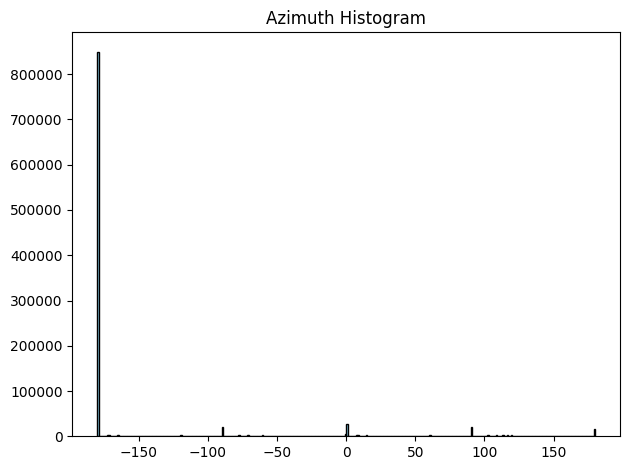

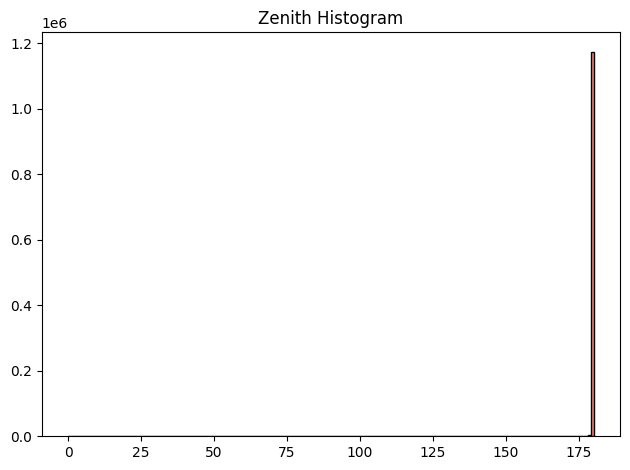

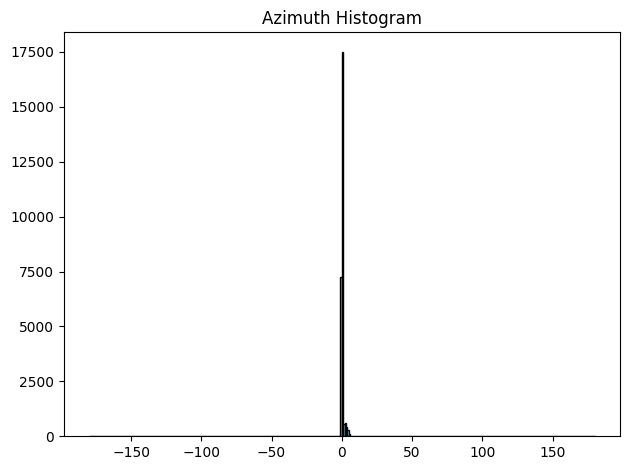

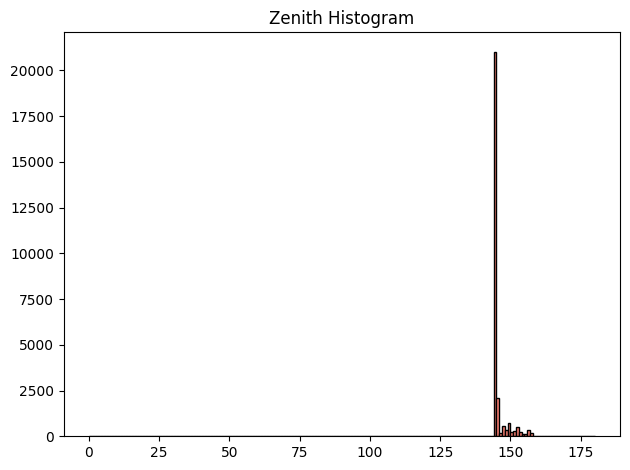

i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 0
i = 1
i = 2
i = 3
i = 4
i

In [5]:
visualizer = ArcLengthCalculator(pcd = pcd, intersection_line=intersection_line, bend_edges=bend_edges, bend_cluster_points=cluster_points, cluster_derivatives=cluster_derivatives, all_normals=all_normals, segment_indices=segment_indices)
df = visualizer.calculate_arc_length()
visualizer.run()

In [6]:
pd.set_option('display.max_rows', None)    # Show all rows
pd.set_option('display.max_columns', None) # Show all columns
pd.set_option('display.width', None)       # Don’t wrap lines
pd.set_option('display.max_colwidth', None) # Show full column content

display(df)

,Sample Index,Base XYZ,Arc Length Forward,Arc Length Backward,Total Arc Length
0,0,"[150.87572977481233, 180.90075062552125, 1.133523941040039]",0.952226,1.134618,2.086844
1,1,"[150.87572977481233, 181.40116763969974, 1.133523941040039]",0.941267,1.114228,2.055495
2,2,"[150.87572977481233, 181.90158465387822, 1.133523941040039]",0.997555,1.112494,2.110050
3,3,"[150.87572977481233, 182.4020016680567, 1.133523941040039]",0.991881,1.118734,2.110616
4,4,"[150.87572977481233, 182.90241868223518, 1.133523941040039]",0.989900,1.118786,2.108686
5,5,"[150.87572977481233, 183.40283569641366, 1.133523941040039]",0.989900,1.118787,2.108687
6,6,"[150.87572977481233, 183.90325271059214, 1.133523941040039]",0.989900,1.118787,2.108687
7,7,"[150.87572977481233, 184.40366972477065, 1.133523941040039]",0.989900,1.176347,2.166246
8,8,"[150.87572977481233, 184.90408673894913, 1.133523941040039]",1.195543,1.278903,2.474446
9,9,"[150.87572977481233, 185.4045037531276, 1.133523941040039]",1.100497,1.308116,2.408613
